In [1]:
# %pip uninstall torch torchvision torchaudio -y
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
%pip install transformers datasets evaluate rouge-score numpy pandas

import time
import numpy as np
import pandas as pd
from transformers import pipeline
from evaluate import load




Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Note: you may need to restart the kernel to use updated packages.


You can safely remove it manually.
You can safely remove it manually.


Looking in indexes: https://download.pytorch.org/whl/cu124Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp312-cp312-win_amd64.whl.metadata (28 kB)
  Using cached https://download.pytorch.org/whl/cu124/torchvision-0.21.0%2Bcu124-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached https://download.pytorch.org/whl/cu124/torchaudio-2.6.0%2Bcu124-cp312-cp312-win_amd64.whl.metadata (6.8 kB)
Using cached https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp312-cp312-win_amd64.whl (2532.3 MB)
Using cached https://download.pytorch.org/whl/cu124/torchvision-0.21.0%2Bcu124-cp312-cp312-win_amd64.whl (6.1 MB)
Using cached https://download.pytorch.org/whl/cu124/torchaudio-2.6.0%2Bcu124-cp312-cp312-win_amd64.whl (4.2 MB)



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


d:\DS_predictive_Analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
text = """The rapid advancements in artificial intelligence have revolutionized various industries.
From healthcare to finance, AI is transforming the way we live and work.
However, ethical considerations and the need for regulation remain critical.
As AI continues to evolve, it is essential to balance innovation with responsibility."""

# List of pre-trained text summarization models
models = [
    "facebook/bart-large-cnn",
    "t5-small",
    "t5-base",
    "google/pegasus-xsum"
]

# Load ROUGE metric for evaluation
rouge = load("rouge")

# Dictionary to store results
evaluation_results = []

# Iterate through each model, generate summary, and evaluate
for model_name in models:
    print(f"\nEvaluating {model_name}...")

    # Load summarization pipeline
    summarizer = pipeline("summarization", model=model_name)

    # Measure inference time
    start_time = time.time()
    summary = summarizer(text, max_length=50, min_length=20, do_sample=False)
    end_time = time.time()

    generated_summary = summary[0]['summary_text']

    # Compute ROUGE scores
    scores = rouge.compute(predictions=[generated_summary], references=[text])

    # Store evaluation metrics
    evaluation_results.append([
    model_name,
    scores['rouge1'],  # ✅ Now correctly accesses the score
    scores['rouge2'],
    scores['rougeL'],
    end_time - start_time  # Inference time
])

# Convert results to a Pandas DataFrame
df = pd.DataFrame(evaluation_results, columns=["Model", "ROUGE-1", "ROUGE-2", "ROUGE-L", "Inference Time"])
print("\nEvaluation Results:")
print(df)

# Save evaluation results to CSV (optional)
df.to_csv("summarization_model_evaluation.csv", index=False)



Evaluating facebook/bart-large-cnn...


Device set to use cuda:0



Evaluating t5-small...


Device set to use cuda:0



Evaluating t5-base...


Device set to use cuda:0



Evaluating google/pegasus-xsum...


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0



Evaluation Results:
                     Model   ROUGE-1   ROUGE-2   ROUGE-L  Inference Time
0  facebook/bart-large-cnn  0.606061  0.562500  0.606061        1.457537
1                 t5-small  0.626866  0.553846  0.626866        0.771573
2                  t5-base  0.647059  0.636364  0.647059        1.621169
3      google/pegasus-xsum  0.176471  0.030303  0.117647        6.559636


In [3]:
from sklearn.preprocessing import MinMaxScaler
data = df.iloc[:, 1:].values

# Normalize using Min-Max scaling
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df.iloc[:, 1:].values)

# Define ideal best (highest ROUGE, lowest inference time) and worst solutions
ideal_best = np.max(normalized_data, axis=0)
ideal_worst = np.min(normalized_data, axis=0)

# Compute Euclidean distances from best and worst
distance_best = np.linalg.norm(normalized_data - ideal_best, axis=1)
distance_worst = np.linalg.norm(normalized_data - ideal_worst, axis=1)

# Compute TOPSIS scores
topsis_score = distance_worst / (distance_best + distance_worst)

# Add TOPSIS score to DataFrame
df["TOPSIS Score"] = topsis_score

# Sort by TOPSIS score (higher is better)
df = df.sort_values(by="TOPSIS Score", ascending=False)

# Save ranked results
df.to_csv("topsis_ranking.csv", index=False)

print("\nFinal Model Ranking (TOPSIS):\n")
print(df)


Final Model Ranking (TOPSIS):

                     Model   ROUGE-1   ROUGE-2   ROUGE-L  Inference Time  \
2                  t5-base  0.647059  0.636364  0.647059        1.621169   
0  facebook/bart-large-cnn  0.606061  0.562500  0.606061        1.457537   
1                 t5-small  0.626866  0.553846  0.626866        0.771573   
3      google/pegasus-xsum  0.176471  0.030303  0.117647        6.559636   

   TOPSIS Score  
2      0.670761  
0      0.636499  
1      0.614089  
3      0.366025  


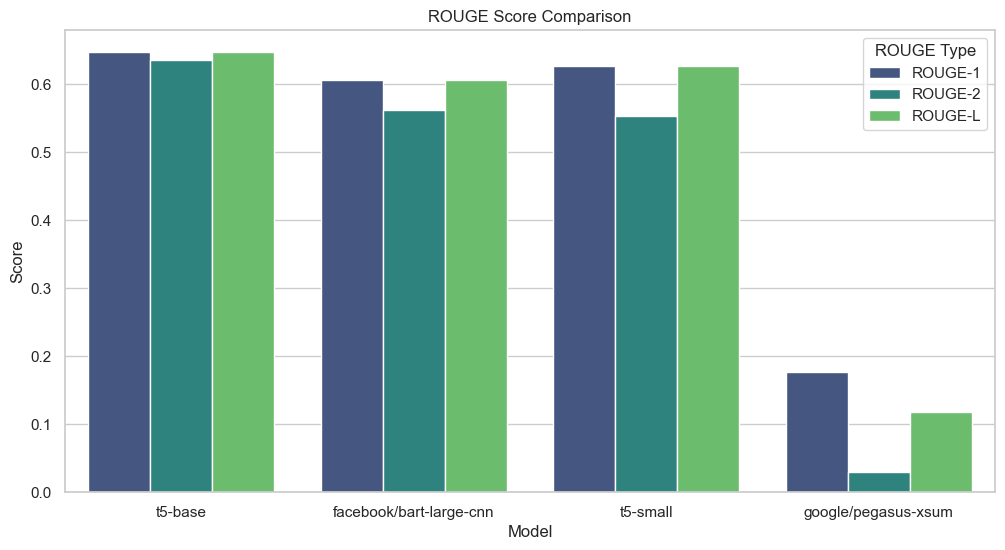

C:\Users\Arnav\AppData\Local\Temp\ipykernel_29084\3118252443.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["Model"], y=df["Inference Time"], palette="magma")


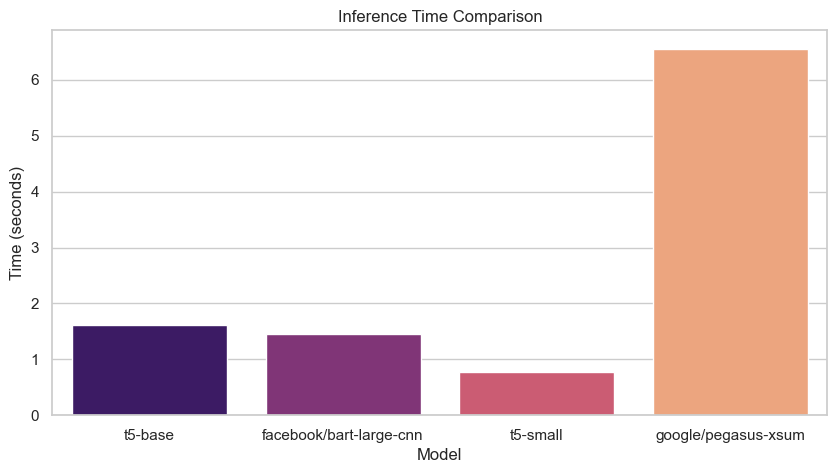

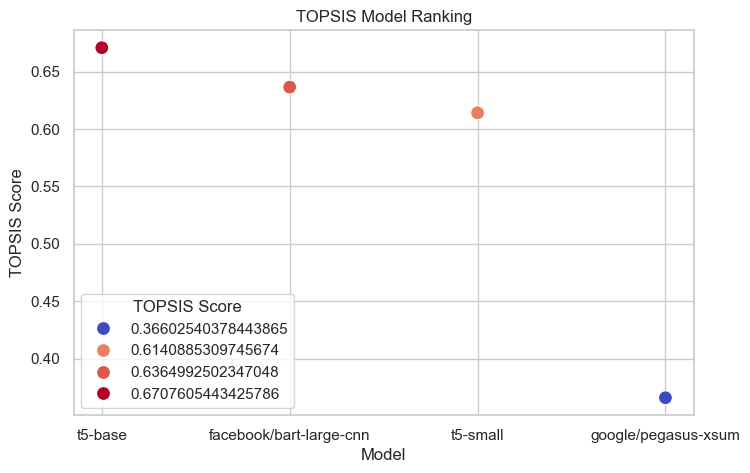

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# ...existing code...
sns.set_theme(style="whitegrid")

# ROUGE Score Comparison
plt.figure(figsize=(12, 6))
df_melted = df.melt(id_vars=["Model"], value_vars=["ROUGE-1", "ROUGE-2", "ROUGE-L"], var_name="ROUGE Type", value_name="Score")
sns.barplot(data=df_melted, x="Model", y="Score", hue="ROUGE Type", palette="viridis")
plt.title("ROUGE Score Comparison")
plt.savefig("rouge_scores.png")
plt.show()

# Inference Time Comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=df["Model"], y=df["Inference Time"], palette="magma")
plt.title("Inference Time Comparison")
plt.ylabel("Time (seconds)")
plt.savefig("inference_time.png")
plt.show()

# TOPSIS Score Visualization
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["Model"], y=df["TOPSIS Score"], hue=df["TOPSIS Score"], palette="coolwarm", s=100)
plt.title("TOPSIS Model Ranking")
plt.ylabel("TOPSIS Score")
plt.savefig("topsis_ranking.png")
plt.show()